<a href="https://colab.research.google.com/github/czhangg17/COVID-19/blob/master/Red_LSTM_serie_pasajeros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ejemplo de red LSTM utilizando la serie pasajeros


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import numpy as np
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

print("Versión de Tensorflow: ", tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


Versión de Tensorflow:  2.2.0


In [2]:
from google.colab import drive
PATH = '/content/drive/My Drive/Mineria de datos/AirPassengers.csv' 
drive.mount('/content/drive')
data=pd.read_csv(PATH, header=0)
data.tail()


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


,Month,NPassengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


## modificamos los datos para que sean una serie temporal

Text(0, 0.5, 'Pasajeros')

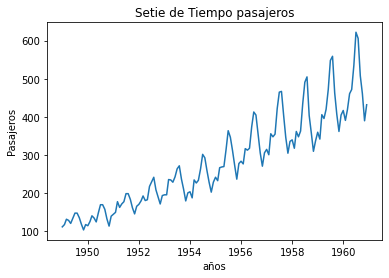

In [3]:
#set_trace()
con=data['Month']
data['Month']=pd.to_datetime(data['Month'])
##data.set_index('Month', inplace=True)
pasajeros=data.set_index('Month')
#check datatype of index
#convert to time series:
tsAirP = pasajeros['NPassengers']
plt.plot(tsAirP)
plt.title('Setie de Tiempo pasajeros')
plt.xlabel('años')
plt.ylabel('Pasajeros')
#type(tsAirP)
#type(pasajeros)

# normalizacion  o escalamiento de los datos 
La normalizacion de los datos se hace con el fin de tener una forma estandarizada de ellos y al entrar por la tanh o por el sigmoide sea mas facil de esocger quienes estan mas cercanos a 1 o  0. Es decir, finalmente es mas facil realizar la clasificacion de los datos sobre los cuales generan la conexion con la siguiente neurona.






In [4]:
# normalizacion de los datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = scaler.fit_transform(pasajeros.values)
dataset=pd.DataFrame(dataset_scaled)
dataset.index=pasajeros.index

In [6]:
dataset.tail()

,0
Month,
1960-08-01,0.969112
1960-09-01,0.779923
1960-10-01,0.689189
1960-11-01,0.552124
1960-12-01,0.633205


# ahora vamos a escoger la cantidad de datos de validacion y entrenamiento
Esogemos 2/3 de los datos para entrenamiento y 1/3 para validación.


In [7]:
# dividimos entre entranmiento y test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train=dataset[:train_size]
test = dataset[train_size:len(dataset)]
print(train_size,test_size)

96 48


Creamos la funcion create_dataset donde reibe como parametro un array de numpy que queremos convertir en un conjunto de datos , y el parametro time_steps, sera el numero de pasos previos que se quiere utilizar en la varaible de entrada para predecir el seiguiente periodo de tiempo, en este caso es 1.

Esta funcion lo que hace es llenar en los valores de Xs y ys con el conjunto de datos donde X es el numero de pasajeros en el momento t+1

In [8]:
# esta funcion nos permite poner en una matriz los datos que se encuentrar en un vector
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)
# semilla aleatoria para reproducibilidad
np.random.seed(7)

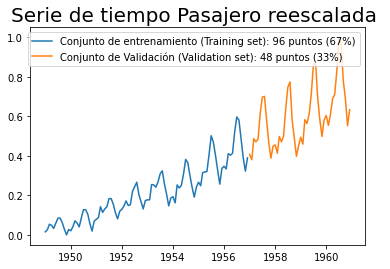

In [9]:
#plt.figure(figsize=(16,8))
len_train=len(train)
len_test=len(test)
plt.plot(train, label='Conjunto de entrenamiento (Training set): ' + str(len_train) +' puntos (67%)')
plt.plot(test, label='Conjunto de Validación (Validation set): '  + str(len_test) + ' puntos (33%)') 
plt.title("Serie de tiempo Pasajero reescalada ", size = 20)
plt.legend()
plt.show()

Usemos la funciona anterior para preparar los datos ya recibiendo los parametros que pide la funcion




In [10]:
time_steps = 1

# reshape to [samples, time_steps, n_features]

X_train, trainY = create_dataset(train, train.values, time_steps)
X_test, testY = create_dataset(test, test.values, time_steps)

print(X_train.shape, trainY.shape)

(95, 1, 1) (95, 1)


In [11]:
print(len(X_train))

95


In [12]:
# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]
trainX = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
testX = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# modelamiento y creacion de red LSTM utilizando keras


In [13]:
#help(keras.layers.LSTM)

Escogemos una modelo donde la capa LSTM tenga 4 neuronas, y solo una capa densa, y las entradas (inputs_shape) de la capa LSTM va a estar dada por la cantidad de datos de entenamiento y de pasos previos a usar 

In [14]:
lstm_output =4 # numero de neuronas (no hay ninguna regla para la escogencia,se hace a partir del refinamiento del modelo)
model = keras.Sequential()
model.add(keras.layers.LSTM(units=lstm_output,  input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dense(units=1))

X_train.shape

(95, 1, 1)

necesitamos compilar el modelo para poder trabajar con él

El optimizador de Adam es de los mas utilizados puesto que se usa el gradiente descendiente estocastico , con 0.001 su tasa de aprendizaje

In [15]:
# compilacion del modelo
model.compile(loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

In [16]:
# numero optimo de parametros
4*(lstm_output*lstm_output + lstm_output*time_steps+ lstm_output)

96

## summary del modelo
tenemos que son 96 parametros , que seria la cantidad de pesos que se deben estimar por cada dato de entrenamiento y dentro de la capa densa solo habra que estimar 5 parametros con un total de 101 parámetros


In [17]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4)                 96        
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


# entrenamiento del modelo


In [18]:
#help(model.fit)

In [19]:
np.random.seed(2020)

In [20]:
history=model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1,shuffle=True, validation_split=0.05)
# verbose simplemente es una forma de como queremos que salgan los epochs
#batch size se refiere al espacio de memoria de se debe utilizar

Epoch 1/100
90/90 [==============================] - 1s 6ms/step - loss: 0.0364 - val_loss: 0.0984
Epoch 2/100
90/90 [==============================] - 0s 2ms/step - loss: 0.0180 - val_loss: 0.0588
Epoch 3/100
90/90 [==============================] - 0s 2ms/step - loss: 0.0134 - val_loss: 0.0439
Epoch 4/100
90/90 [==============================] - 0s 2ms/step - loss: 0.0123 - val_loss: 0.0393
Epoch 5/100
90/90 [==============================] - 0s 2ms/step - loss: 0.0115 - val_loss: 0.0336
Epoch 6/100
90/90 [==============================] - 0s 2ms/step - loss: 0.0108 - val_loss: 0.0279
Epoch 7/100
90/90 [==============================] - 0s 2ms/step - loss: 0.0099 - val_loss: 0.0261
Epoch 8/100
90/90 [==============================] - 0s 2ms/step - loss: 0.0091 - val_loss: 0.0226
Epoch 9/100
90/90 [==============================] - 0s 2ms/step - loss: 0.0082 - val_loss: 0.0187
Epoch 10/100
90/90 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0134
Epoch 11/

#grafica de la funcion de perdida


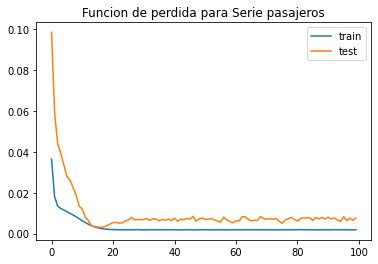

In [21]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Funcion de perdida para Serie pasajeros')
plt.legend();

# predicciones

In [22]:
# hacemos las predicciones sobre el conjunto de entreamiento de y validacion
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [23]:
# invertimos las predicciones
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

In [24]:
# calculamos el error rms
import math
from sklearn.metrics import mean_squared_error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Resultado del entrenamiento: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Resultado del test: %.2f RMSE' % (testScore))

Resultado del entrenamiento: 23.95 RMSE
Resultado del test: 47.88 RMSE


In [25]:
 #predicciones del entrenamiento de cambio para plotear
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_steps:len(trainPredict)+time_steps ] = trainPredict

In [26]:
# predicciones del test de cambio para plotear
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+1:len(dataset)-1, :] = testPredict

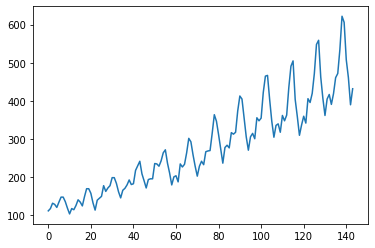

In [27]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))

vemos con la siguiente grafica que el modelo ajusta bastante bien , pues los datos de validacion son muy cercanos a los reales de la serie original , sin necesidad de tener en cueta estacionalidad y algun tipo de tendencia podemos ajustar en modelo a las redes neuronales artificiales LSTM

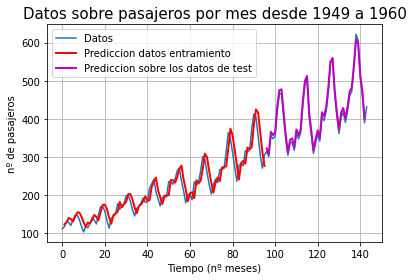

In [28]:
# ploteamos linea base y predicciones
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot,'r', linewidth = 2)
plt.plot(testPredictPlot,'m', linewidth = 2)
plt.legend( ('Datos', 'Prediccion datos entramiento', 'Prediccion sobre los datos de test'), loc = 'upper left')
plt.grid(True)
plt.title("Datos sobre pasajeros por mes desde 1949 a 1960", fontsize = 15)
plt.xlabel("Tiempo (nº meses)", fontsize = 10)
plt.ylabel("nº de pasajeros", fontsize = 10)
plt.show()


#Veamos las predicciones de cerca

In [29]:
# predicciones del testY de cambio para plotear
testYPlot = np.empty_like(dataset)
testYPlot[:, :] = np.nan
testYPlot[len(trainPredict)+1:len(dataset)-1, :] = testY

Text(0.5, 1.0, 'zoom de las predicciones de test')

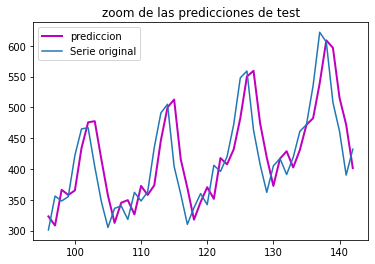

In [30]:
plt.plot(testPredictPlot,'m', linewidth=2)

plt.plot(testYPlot)
plt.legend(("prediccion",'Serie original'))
plt.title('zoom de las predicciones de test')

In [ ]:
print(testPredict)
print(testY)

## a 12 pasos previos

In [32]:
time_steps=12
# reshape to [samples, time_steps, n_features]

X_train, trainY = create_dataset(train, train.values, time_steps)
X_test, testY = create_dataset(test, test.values, time_steps)

print(X_train.shape, trainY.shape)

(84, 12, 1) (84, 1)


In [33]:
 #remodelamos la entrada para que sea[muestras, pasos de tiempo, características]
trainX = np.reshape(X_train, (X_train.shape[0], 12, 1))
testX = np.reshape(X_test, (X_test.shape[0], 12, 1))


In [34]:
X_train.shape[1]

12

In [35]:
lstm_output =4 # numero de neuronas (no hay ninguna regla para la escogencia,se hace a partir del refinamiento del modelo)
model = keras.Sequential()
model.add(keras.layers.LSTM(units=lstm_output,  input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dense(units=1))
X_train.shape

# compilacion del modelo
model.compile(loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.001)
)

# numero optimo de neuronas
4*(lstm_output*lstm_output + lstm_output*time_steps+ lstm_output)

history=model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1,shuffle=True, validation_split=0.05)



Epoch 1/100
79/79 [==============================] - 1s 8ms/step - loss: 0.0323 - val_loss: 0.0453
Epoch 2/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0092 - val_loss: 0.0227
Epoch 3/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0078 - val_loss: 0.0190
Epoch 4/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0066 - val_loss: 0.0141
Epoch 5/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0056 - val_loss: 0.0122
Epoch 6/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0048 - val_loss: 0.0107
Epoch 7/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0096
Epoch 8/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0041 - val_loss: 0.0096
Epoch 9/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0096
Epoch 10/100
79/79 [==============================] - 0s 3ms/step - loss: 0.0038 - val_loss: 0.0103
Epoch 11/

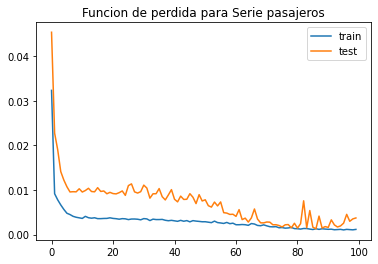

In [36]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Funcion de perdida para Serie pasajeros')
plt.legend();

In [37]:
# hacemos las predicciones
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invertimos las predicciones
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

# calculamos el error rms
import math
from sklearn.metrics import mean_squared_error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
print('Resultado del entrenamiento: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Resultado del test: %.2f RMSE' % (testScore))



Resultado del entrenamiento: 16.76 RMSE
Resultado del test: 98.97 RMSE


In [38]:
#predicciones del entrenamiento de cambio para plotear
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[time_steps:len(trainPredict)+time_steps ] = trainPredict

In [39]:
#predicciones del test de cambio para plotear
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+12:len(dataset)-12, :] = testPredict

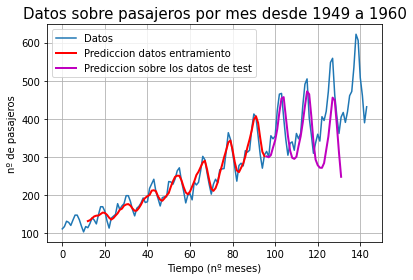

In [40]:
 #ploteamos linea base y predicciones
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot,'r', linewidth = 2)
plt.plot(testPredictPlot,'m', linewidth = 2)
plt.legend( ('Datos', 'Prediccion datos entramiento', 'Prediccion sobre los datos de test'), loc = 'upper left')
plt.grid(True)
plt.title("Datos sobre pasajeros por mes desde 1949 a 1960", fontsize = 15)
plt.xlabel("Tiempo (nº meses)", fontsize = 10)
plt.ylabel("nº de pasajeros", fontsize = 10)
plt.show()

Text(0.5, 1.0, 'zoom de las predicciones de test')

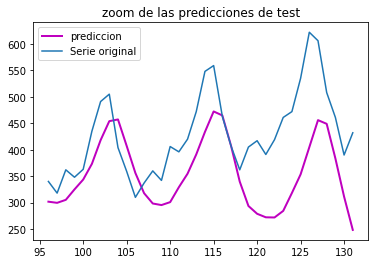

In [41]:
# predicciones del testY de cambio para plotear
testYPlot = np.empty_like(dataset)
testYPlot[:, :] = np.nan
testYPlot[len(trainPredict)+12:len(dataset)-12, :] = testY

plt.plot(testPredictPlot,'m', linewidth=2)

plt.plot(testYPlot)
plt.legend(("prediccion",'Serie original'))
plt.title('zoom de las predicciones de test')